# RF Estimation using segmentation 

**This notebook is the first implementation of a segmented MRFs **




In [1]:
# Ignore Warnings
from warnings import simplefilter
simplefilter('ignore')

%reload_ext autoreload
%autoreload 2

In [2]:
# Dependencies - General Stuff
import sys
import os
import numpy as np
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
from glob import glob
from scipy.signal import windows, fftconvolve
from scipy.io import wavfile
from scipy.special import genlaguerre
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
import seaborn as sns

# Depednecies from Theunissen Lab
# sys.path.append("/Users/frederictheunissen/Code/soundsig/")
from soundsig.sound import BioSound
from soundsig.sound import spec_colormap

# strfpy
sys.path.append("/Users/frederictheunissen/Code/strfPy/module/")
from strfpy.makePSTH import SpikeResponse
from strfpy import findDatasets, preprocSound, strfSetup, trnDirectFit, plotTfrep
# from strflab import preprocess_sound, srdata2strflab, linInit, strfData, trnDirectFit, strfOpt


# %matplotlib widget
plt.ion();

Set up the path

In [3]:
# Change these paths to point at your data and stimulus directories
path_base = os.path.join('/Users/frederictheunissen/Code/strfPy')
path_base = '/aquila_ssd2/lthomas/Projects/pySTRF_exampledata'
path_base = 'Data'
# dataDir = os.path.join(path_base, 'data')  # contains stim/response pairs
stimsDir = os.path.join(path_base, 'all_stims')  # contains the .wav files


load and visualize single unit data from Theunissen lab

In [4]:
# Specify the directory for three brain regions and three example neurons in each
cellDirName = 'l2a_good'
cellDir = os.path.join(path_base,cellDirName, 'conspecific')


In [5]:
# Get the stimulus and response files from the cell directory
datasets = findDatasets.find_datasets(cellDir, stimsDir)
cellStimDir = datasets['dirname']
stimFiles = datasets['srPairs']['stimFiles']  # paths to .wav files
respFiles = datasets['srPairs']['respFiles']  # paths to spike* files

In [6]:
# Preprocess the sound stimuli by taking the short time Fourier transform, and preprocess the raw spike
# times into PSTHs for each stim/response pair.
preprocDir = os.path.join(cellStimDir, 'preproc') # cache the preprocessed data here
os.makedirs(preprocDir, exist_ok=True)
preprocOptions = {} # we'll leave this empty and use default options


In [7]:
# Make a directory to save figures
figDir = os.path.join(cellStimDir, 'figures')
os.makedirs(figDir, exist_ok=True)

In [8]:
# set up datasets
srData = preprocSound.preprocess_sound(stimFiles, respFiles, preprocess_type='ft', stim_params = preprocOptions, output_dir = preprocDir)
pairCount = len(srData['datasets']) # number of stim/response pairs
nStimChannels = srData['nStimChannels']


In [13]:
# generate 15 log spaced frequencies between 200 and 8000 Hz
def log_downsample_spec(spec, f, nbins, fmin=200,fmax=8000):
    nbins = 18
    log_freqs = np.logspace(np.log10(fmin), np.log10(fmax), nbins+1)
    log_midpoints = (log_freqs[1:] + log_freqs[:-1]) / 2
    # bin the frequencies into 15 log spaced bins
    f_bins = np.searchsorted(log_freqs, f) - 1
    out_log_spec = np.zeros((nbins, spec.shape[1]))
    for i in range(nbins):
        out_log_spec[i] = np.mean(spec[f_bins == i,:], axis=0)
    #plt.imshow(out_log_spec, aspect='auto',origin='lower', extent=[t.min(), t.max(), 0, nbins])
    #plt.yticks(np.arange(nbins)+.5,log_midpoints.astype(int));
    return out_log_spec, log_midpoints


### Generate the stimulus and response feature
The stimulus features are the MPS obtained for each song segment.  The song segments are obtained using a hard threshold and then merging short silences and short sounds.
The response feature is the PSTH smoothed with a hanning window.

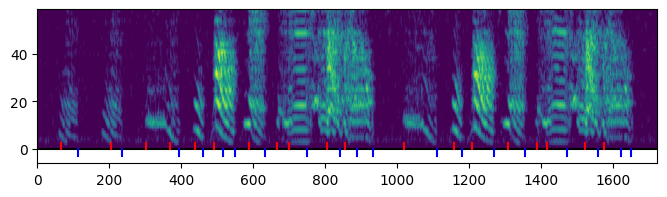

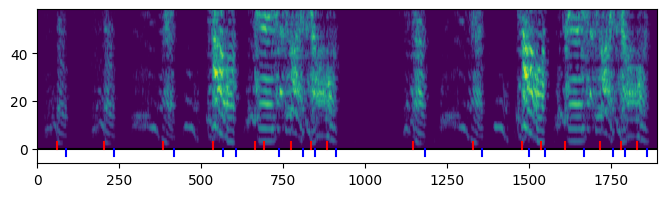

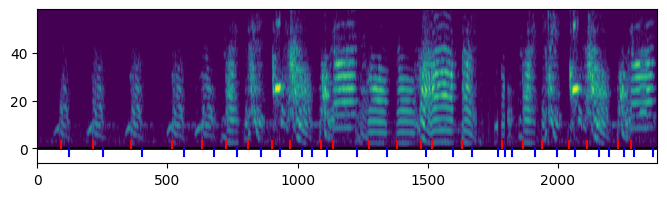

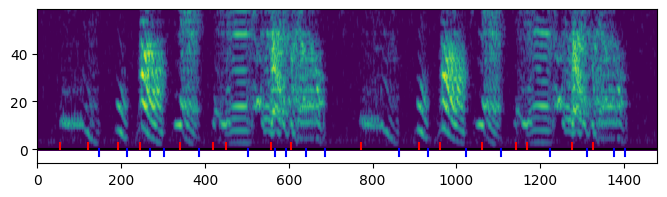

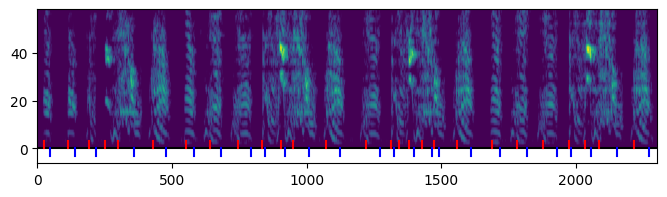

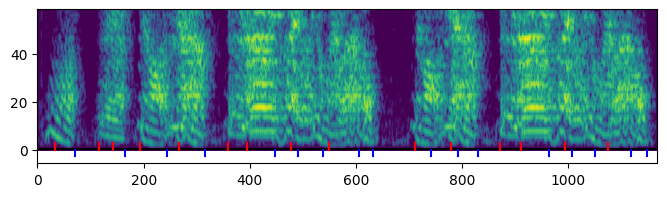

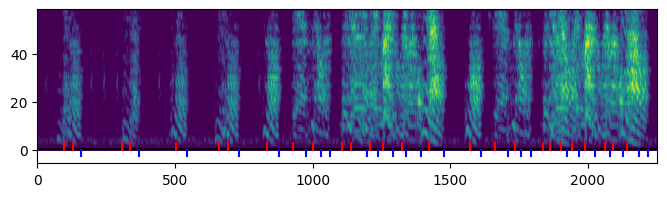

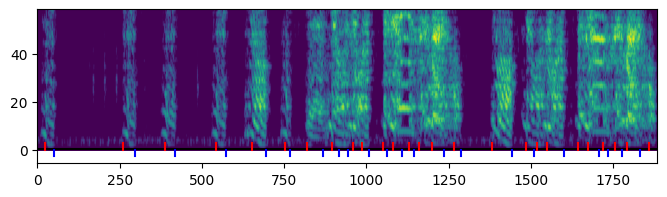

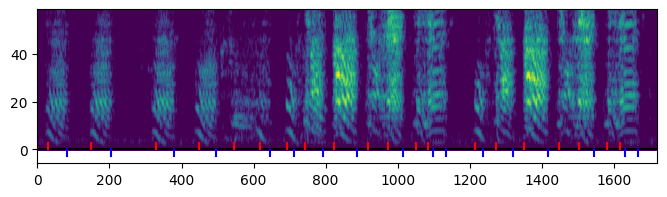

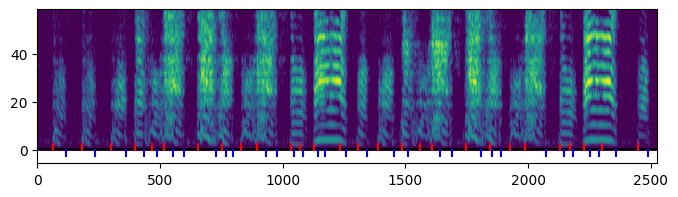

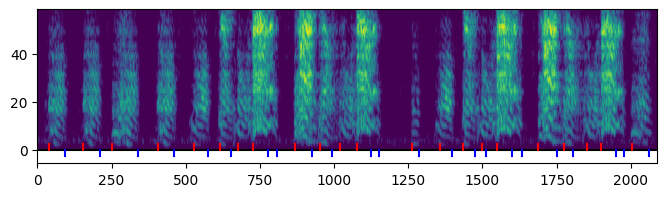

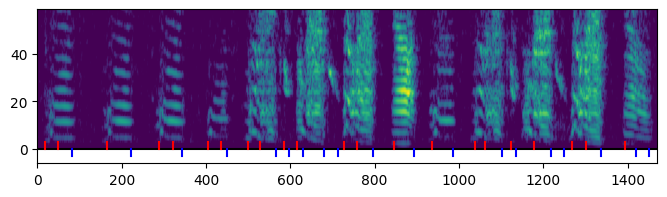

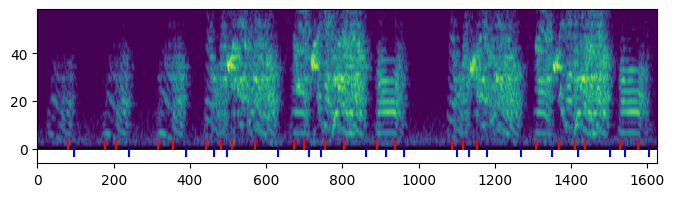

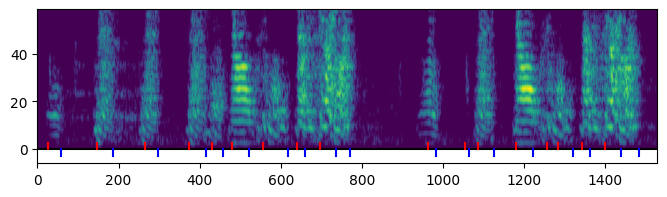

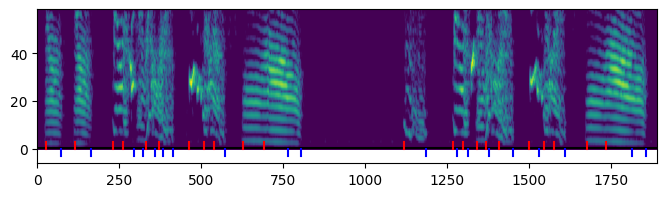

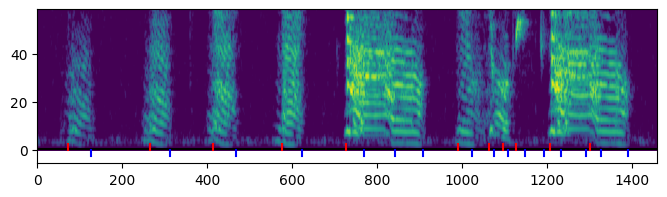

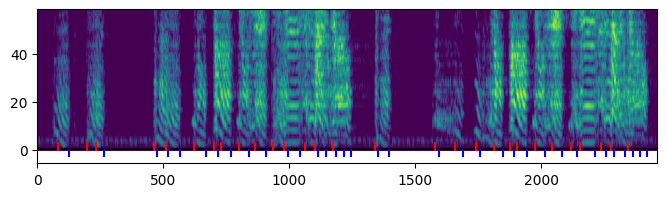

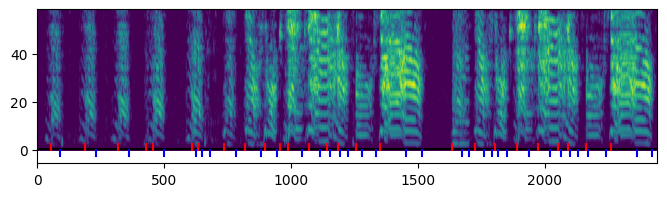

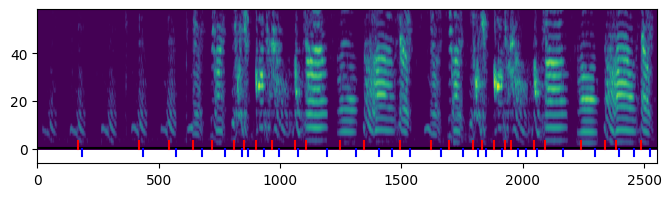

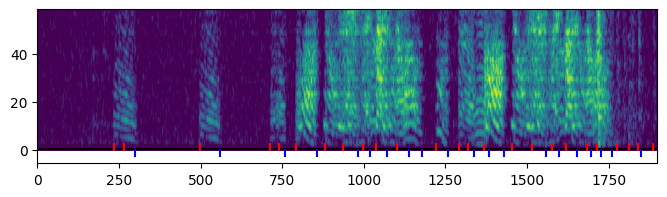

In [18]:
# PREPROCESSING
# - Segmentation of the stimulus based on the envelope
# - Calculation of the spectrogram
# - Calculation of the PSTH
# - Calculation of the MPS

# Segmentation based on derivative of the envelope
plot = True
ampThresh = 20.0  # Threshold in dB where 50 is max

minSound = 25  # Minimum distance between peaks or troffs
derivativeThresh = 0.2  # Thresnold derivative 0.5 dB per ms.
segmentBuffer = 100 # Number of points on each side of segment for response and MPS - time units given by stim sample rate
respChunkLen = 200 # Total chunk length (including segment buffer) in number of points 
DBNOISE = 50  # Set a baseline for everything below 70 dB from max


wHann = windows.hann(21, sym=True)   # The 21 ms (number of points) hanning window used to smooth the PSTH
wHann = wHann/sum(wHann)

srData

for iSet in range(pairCount) :
    events = dict({
        'index': [],
        'feature': [[]],
    })

    # Stimulus wave file and amplitude enveloppe from spectrogram
    waveFile = srData['datasets'][iSet]['stim']['rawFile']
    fs , soundStim = wavfile.read(waveFile)
    soundLen = soundStim.size
    spectro = np.copy(srData['datasets'][iSet]['stim']['tfrep']['spec'])
    dBMax = spectro.max()
    spectro[spectro < dBMax-DBNOISE] = dBMax-DBNOISE
    # set the y ticks to freq
    nFreqs = len(srData['datasets'][iSet]['stim']['tfrep']['f'])

    ampenv = np.mean(spectro, axis=0)
    ampfs = srData['datasets'][iSet]['stim']['sampleRate']

    nSound = int((respChunkLen)*fs/ampfs)   # number of time points in sound chunks - should be the same for all stimulus-response pairs

    ampenv = np.convolve(ampenv, wHann, mode='same')
    ampdev = ampenv[1:]-ampenv[0:-1]
    
    # Find peaks and troughs
    peakInd, peakVals = find_peaks(ampdev, height = derivativeThresh, distance=minSound)
    troughInd, troughVals = find_peaks(-ampdev, height= derivativeThresh, distance=minSound)
    events['index'].extend(peakInd)
    events['onoff_feature'] =  np.vstack([np.ones(len(peakInd), dtype=int), np.zeros(len(peakInd), dtype=int)]).T
    events['index'].extend(troughInd)
    events['onoff_feature'] = np.concatenate( [events['onoff_feature'],np.vstack([np.zeros(len(troughInd), dtype=int), np.ones(len(troughInd), dtype=int)]).T])
    # sort the features by index
    events['onoff_feature'] = events['onoff_feature'][np.argsort(events['index'])]
    events['index'] = np.sort(events['index'])

    # now get the features from the spectrogram

    # pad the spectrogram with zeros to make sure we have enough points for windowing
    padded_spect = np.pad(spectro, ((0,0), (respChunkLen, respChunkLen)), 'constant', constant_values=(dBMax-DBNOISE, dBMax-DBNOISE))
    # now get the sliding window view
    spect_windows = np.lib.stride_tricks.sliding_window_view(padded_spect, respChunkLen,axis=1)
    # now get the indices of the start of the spectrograms
    # for ON features we take the index of the peak and subtract the segment buffer
    # for OFF features we take the index of the trough and subtract the respChunkLen
    spect_inds = events['index'] + respChunkLen - segmentBuffer * events['onoff_feature'][:,0] - (respChunkLen - segmentBuffer) * events['onoff_feature'][:,1]
    events['spect_windows'] = spect_windows[:, spect_inds,:].swapaxes(0,1)
    events['spect_inds'] = spect_inds

    # now create the features
    nFeats = nStimChannels*respChunkLen
    spect_feats = events['spect_windows'].reshape((len(events['index']), nFeats))

    # now get the features from the log spectrogram
    events['log_spect_windows'] = []
    for i in range(len(events['index'])):
        spect = events['spect_windows'][i]
        log_spect,log_freqs = log_downsample_spec(spect, srData['datasets'][iSet]['stim']['tfrep']['f'], 18)
        events['log_spect_windows'].append(log_spect)
        events['log_spec_freqs'] = log_freqs
    events['log_spec_windows'] = np.asarray(events['log_spect_windows'])
    
    # now get the response
    srData['datasets'][iSet]['events'] = events

    # smooth the psth
    srData['datasets'][iSet]['resp']['psth_smooth'] = np.convolve(srData['datasets'][iSet]['resp']['psth'], wHann, mode='same')

    if plot:
        plt.figure(figsize=(8,2), dpi=100)
        #plt.plot(ampdev)

        #plt.figure()
        plt.imshow(spectro, aspect='auto', cmap=spec_colormap(), origin='lower')    
        plt.axhline(derivativeThresh, color = 'k')

        for soundStart in peakInd:
            soundFinish = np.argwhere(troughInd >= soundStart + minSound)
            if soundFinish.shape[0]:
                dt = troughInd[soundFinish[0][0]]-soundStart
                # print (soundStart, soundEnd[soundFinish[0][0]], dt)   
                if dt < minSound:
                    print('WARNING - not expecting short sound here', int(soundStart), int(troughInd[soundFinish[0][0]]+1))

        for soundStart in peakInd:
            plt.plot([soundStart, soundStart], [0, np.max(ampdev)*1.1], 'r')

        for soundEnd in troughInd:
            plt.plot([soundEnd, soundEnd], [0, -np.max(ampdev)*1.1], 'b')


In [19]:
# parameters for fit
nLaguerre = 5
nPoints = 200
event_types = 'onoff_feature'
nEventTypes =  srData['datasets'][0]['events']['onoff_feature'].shape[1]


In [23]:
# Use PCA to reduce the dimensionality of the spectrogram features
feature = 'log_spect_windows'
all_spect_windows = np.concatenate([np.asarray(srData['datasets'][iSet]['events'][feature]).reshape((len(srData['datasets'][iSet]['events']['index']), nFeats)) for iSet in range(pairCount)], axis=0)
npcs = 20
pca = PCA(n_components=npcs)
pca.fit(all_spect_windows)
for iSet in range(pairCount):
    events = srData['datasets'][iSet]['events'][event_types]
    n_events = len(srData['datasets'][iSet]['events']['index'])
    spect_pca_features = pca.transform(srData['datasets'][iSet]['events'][feature].reshape((n_events, nFeats)))
    srData['datasets'][iSet]['events']['pca_%s'%feature] = np.zeros((n_events, nEventTypes*npcs))
    for iEventType in range(events.shape[1]):
        srData['datasets'][iSet]['events']['pca_%s'%feature][events[:,iEventType]==1,iEventType*npcs:(iEventType+1)*npcs] = spect_pca_features[events[:,iEventType]==1,:]


ValueError: cannot reshape array of size 136800 into shape (38,11800)

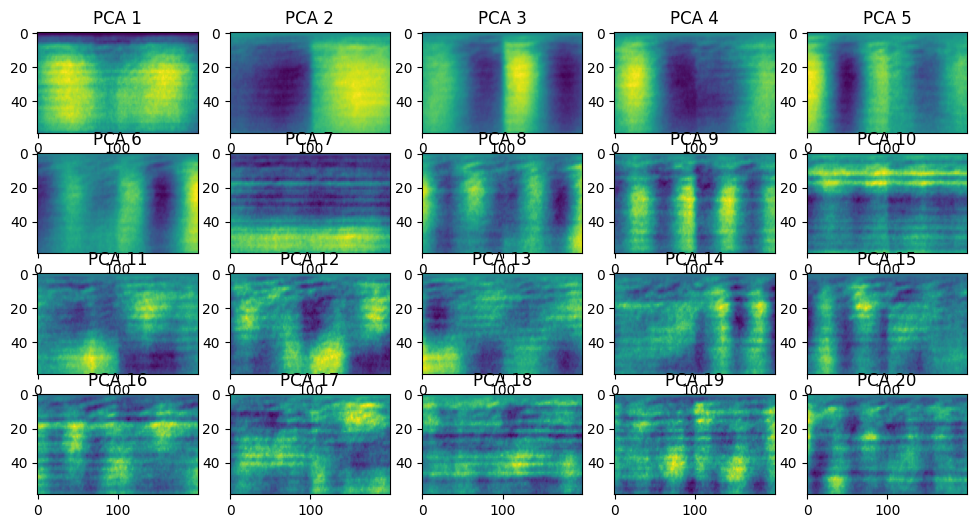

In [93]:
# plot pca components, two rows of 5
nCols = 5
nRows = npcs // nCols
fig, axs = plt.subplots(nRows, nCols, figsize=(12, 6))
for i in range(npcs):
    ax = axs[i // nCols, i % nCols]
    ax.imshow(pca.components_[i].reshape(nStimChannels, respChunkLen), aspect='auto', cmap='viridis')
    ax.set_title(f'PCA {i+1}')

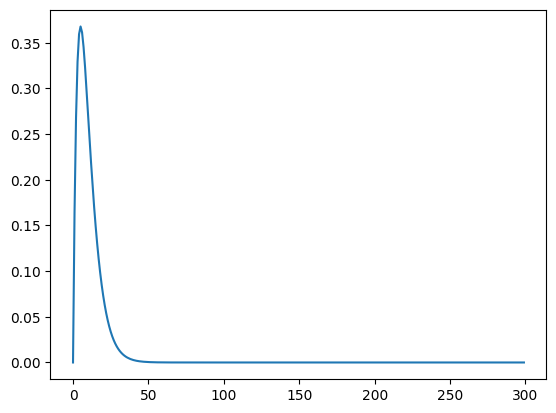

In [94]:
def laguerre(xt, amp, tau, alpha, xorder ):
    return amp * np.exp(-xt/tau)*np.power(xt/tau, alpha)*genlaguerre(xorder, alpha)(xt/tau)
x_t = np.arange(0,300)
laguerre_func_1_amp = laguerre(x_t,amp=1, tau=5, alpha=1,xorder=0)
plt.plot(x_t, laguerre_func_1_amp)


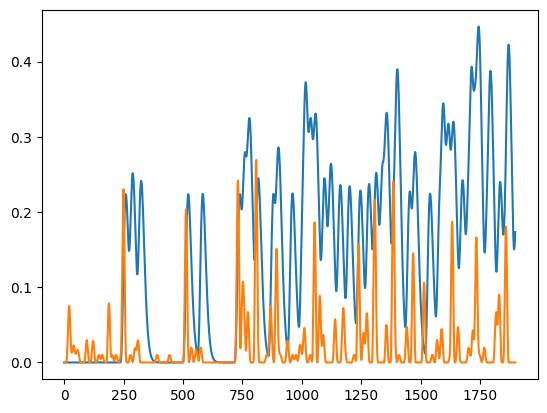

In [95]:
def arbitrary_kernel(pair, nPoints=200):
    nT = pair['resp']['psth'].size
    feature = pair['events']['onoff_feature']
    X = np.zeros((nPoints*2, nT))
    X[:nPoints,pair['events']['index']] = feature[:,0]
    X[nPoints:,pair['events']['index']] = feature[:,1]
    kern_mat = np.vstack([np.eye(nPoints),np.eye(nPoints)])
    X = fftconvolve(X, kern_mat, axes=1, mode='full')[:,:nT]
    return X

# To generate features we will convolve the laguerre function with the feature values
def generate_laguerre_features(pair, feature_key, laguerre_args=np.zeros((2,3)), nLaguerrePoints=300, nLaguerre=5): #nLaguerre=5, laguerre_dt_s=0, laguerre_amp=1, laguerre_tau=5, laguerre_alpha=5):
    # we will generate X and Y for each pair
    # laguerre_args should be a numpy array of size nEventsTypes x 3
    nEventsTypes = laguerre_args.shape[0]
    nT = pair['resp']['psth'].size
    nFeatures = pair['events'][feature_key].shape[1]
    assert(nFeatures % nEventsTypes == 0) # we expect the number of features to be a multiple of the number of event types
    nFeaturesPerEventType = nFeatures // nEventsTypes
    # the features are organized in the following way:
    # the first nFeatures/nEventTypes features are for the first event type, the second nFeatures/nEventTypes are for the second event type, ...
    X = np.zeros((nFeatures*nLaguerre, nT))

    # laguerre functions for each order
    # the order of the matrix's rows are: Laguerre order 0-nLaguerre for feature 1, Laguerre order 0-nLaguerre for feature 2, ...
    laguerre_mat = np.zeros(( nFeatures*nLaguerre,nLaguerrePoints))
    x_t = np.arange(nLaguerrePoints)
    for iFeature in range(nFeaturesPerEventType):
        for iEventType in range(nEventsTypes):
            laguerre_amp, laguerre_tau, laguerre_alpha = laguerre_args[iEventType]
            for iLaguerre in range(nLaguerre):
                y = laguerre(x_t, amp=laguerre_amp, tau=laguerre_tau, alpha=laguerre_alpha, xorder=iLaguerre)
                laguerre_mat[iFeature*nLaguerre+iLaguerre+nFeaturesPerEventType*iEventType,:] = y / np.sqrt(np.sum(y**2))
    # for each event we will convolve the laguerre function with the feature value
    inds = pair['events']['index']# + int(laguerre_dt_s*srData['datasets'][iSet]['resp']['sampleRate'])
    #inds = np.clip(inds, 0, nT-1)
    X[:,pair['events']['index']] = np.hstack([pair['events'][feature_key]]*nLaguerre).T
    # now convolve the laguerre function with the feature value
    X = fftconvolve(X, laguerre_mat, axes=1, mode='full')[:,:nT]
    return X
X_test = generate_laguerre_features(srData['datasets'][iSet], 'onoff_feature', np.array([[2,5,5],[1,5,5]]), nLaguerrePoints=nPoints, nLaguerre=1)
plt.plot(X_test.sum(axis=0))
plt.plot(srData['datasets'][iSet]['resp']['psth_smooth'])

In [96]:

X = None
Y = None
# save 5 for testing
pair_test_set = np.random.choice(range(pairCount), 5, replace=False)
pair_train_set = np.setdiff1d(range(pairCount), pair_test_set)
for iSet in pair_train_set:
    pair = srData['datasets'][iSet]
    x = arbitrary_kernel(pair, nPoints=nPoints)
    if X is None:
        X = x
    else:
        X = np.hstack([X, x])
    if Y is None:
        Y = pair['resp']['psth_smooth']
    else:
        Y = np.hstack([Y, pair['resp']['psth_smooth']])

ridge_conv_filter = RidgeCV()
ridge_conv_filter.fit(X.T, Y)

RidgeCV()

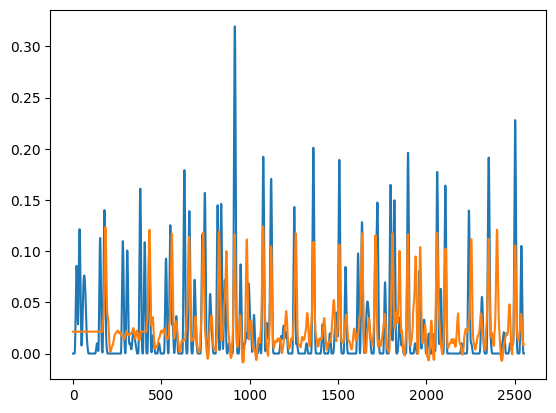

In [46]:

iSet = np.random.choice(pair_train_set)
pair = srData['datasets'][iSet]
y = pair['resp']['psth_smooth']
x = arbitrary_kernel(pair, nPoints=nPoints)
y_pred = ridge_conv_filter.predict(x.T)
plt.plot(y)
plt.plot(y_pred)

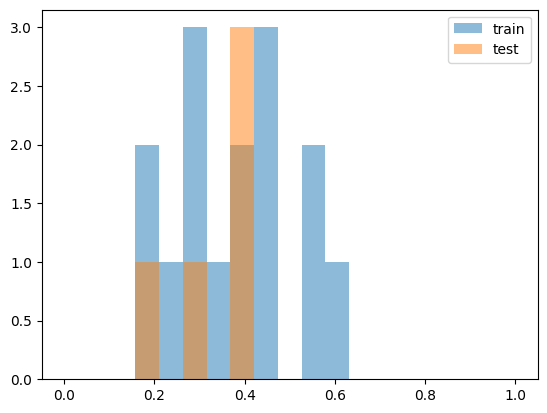

In [47]:

def get_simple_prediction_r2(pair, ridge_conv_filter, nPoints):
    y = pair['resp']['psth_smooth']
    x = arbitrary_kernel(pair, nPoints=nPoints)
    y_pred = ridge_conv_filter.predict(x.T)
    return np.corrcoef(y, y_pred)[0,1]**2

simple_r2_train = [get_simple_prediction_r2(srData['datasets'][iSet], ridge_conv_filter, nPoints) for iSet in pair_train_set]
simple_r2_test = [get_simple_prediction_r2(srData['datasets'][iSet], ridge_conv_filter, nPoints) for iSet in pair_test_set]

bins = np.linspace(0, 1, 20)
plt.hist(simple_r2_train, bins=bins, alpha=0.5, label='train')
plt.hist(simple_r2_test, bins=bins, alpha=0.5, label='test')
plt.legend()

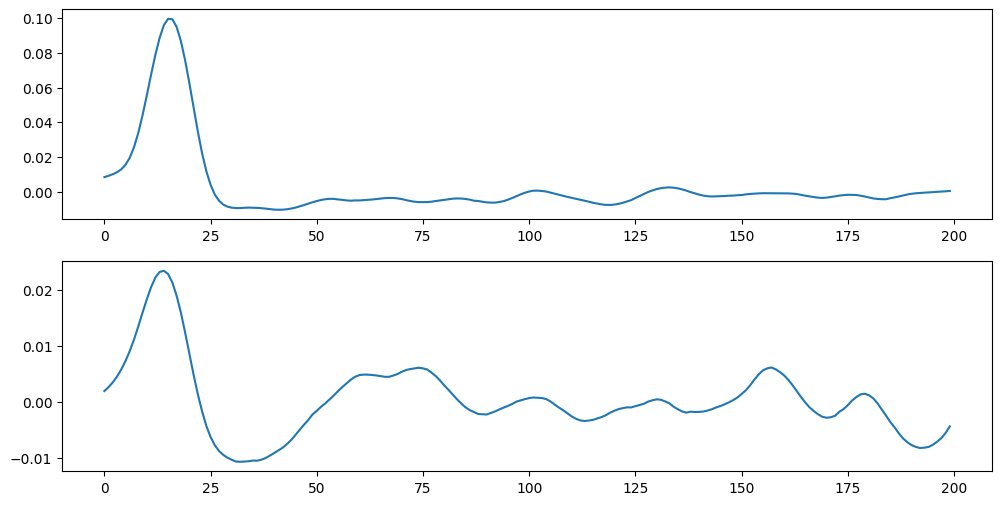

In [48]:
# lets plot all the onset responses
fig, axs = plt.subplots(nEventTypes, 1, figsize=(12, 6))
learned_conv_kernel = ridge_conv_filter.coef_.reshape(2, nPoints)
for iEventType in range(nEventTypes):
    axs[iEventType].plot(learned_conv_kernel[iEventType,:])



Amp 0.000000 Tau 1.376727 Alpha 10.464312
Amp 0.000110 Tau 4.022709 Alpha 5.930574

Amp 0.000001 Tau 1.384462 Alpha 8.890437
Amp 1.869595 Tau 9.451952 Alpha 2.938886


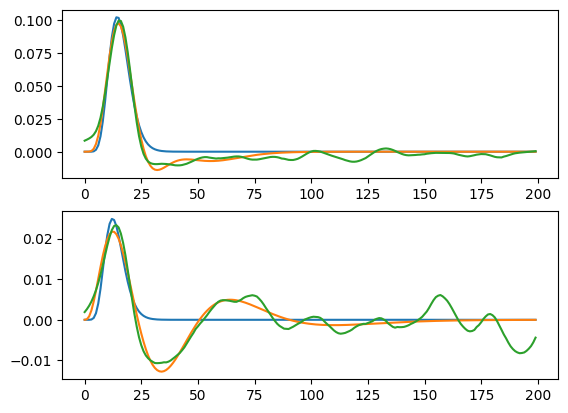

In [51]:
# fit a laguerre to those two
from functools import partial
partial_laguerre = partial(laguerre, xorder=0)
def sum_n_laguerres(xt, *args):
    amp, tau, alpha, *w = args
    nL = len(w)
    out = np.zeros_like(xt,dtype=float)
    for iL in range(nL):
        out += w[iL] * laguerre(xt, amp, tau, alpha, xorder=iL)
    return out

laguerre_args = np.zeros((nEventTypes,3))
for iEventType in range(nEventTypes):
    plt.subplot(nEventTypes,1,iEventType+1)
    print()
    popt, pcov = curve_fit(partial_laguerre, np.arange(nPoints), learned_conv_kernel[iEventType,:], p0=[2, 6, 5], bounds=([ -np.inf, -np.inf, 0], [np.inf, np.inf, np.inf]))
    plt.plot(np.arange(nPoints), laguerre(np.arange(nPoints), *popt, xorder=0))
    # second_lag_params = [popt[0], popt[1]*3, popt[2]]
    # plt.plot(np.arange(nPoints), laguerre(np.arange(nPoints), *second_lag_params, xorder=0))
    print("Amp %f Tau %f Alpha %f"%(popt[0], popt[1], popt[2]))
    popt, pcov = curve_fit(sum_n_laguerres, np.arange(nPoints), learned_conv_kernel[iEventType,:], p0=[2, 6, 5,1,1,1,1])
    print("Amp %f Tau %f Alpha %f"%(popt[0], popt[1], popt[2]))
    plt.plot(np.arange(nPoints), sum_n_laguerres(np.arange(nPoints), *popt))
    plt.plot(learned_conv_kernel[iEventType,:])
    laguerre_args[iEventType,:] = popt[:3]

#laguerre_args[:,0] = learned_conv_kernel.max(axis=1) / 5

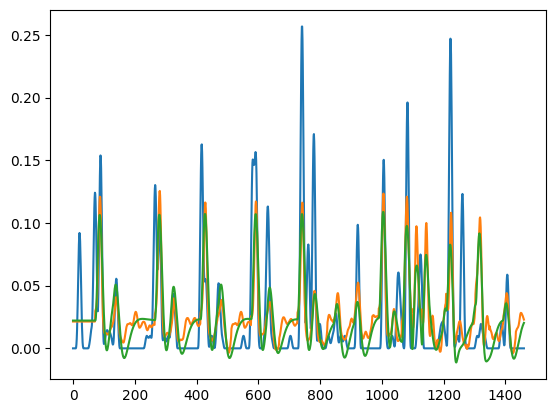

In [52]:
def gen_y_avg_laguerre(pair, laguerre_args, nPts):
    x = generate_laguerre_features(pair, 'onoff_feature', laguerre_args, nLaguerrePoints=nPts, nLaguerre=5)
    y = pair['resp']['psth_smooth']
    ridge = RidgeCV()
    ridge.fit(x.T, y)
    return ridge.predict(x.T)
    # y = pair['resp']['psth_smooth']
    # y = y - x.sum(axis=0)
    # return x.sum(axis=0)

def gen_y_avg(pair, ridge_conv_filter):
    x = arbitrary_kernel(pair, nPoints=nPoints)
    y_pred = ridge_conv_filter.predict(x.T)
    return y_pred

iSet = np.random.choice(pair_test_set)
pair = srData['datasets'][iSet]
y = pair['resp']['psth_smooth']
y_pred = gen_y_avg(pair, ridge_conv_filter)
y_pred_lag = gen_y_avg_laguerre(pair, laguerre_args, nPoints)


plt.plot(y)
plt.plot(y_pred)
plt.plot(y_pred_lag)

In [53]:

Y_avg_removed = None
X = None
nPoints = 200
for iSet in pair_train_set:
    pair = srData['datasets'][iSet]
    x = generate_laguerre_features(pair, 'spect_pca_features',  laguerre_args, nLaguerrePoints=nPoints, nLaguerre=nLaguerre)
    #y = pair['resp']['psth_smooth'] - gen_y_avg_laguerre(pair, laguerre_args, nPoints)
    y = pair['resp']['psth_smooth'] - gen_y_avg(pair, ridge_conv_filter)
    if X is None:
        X = x
    else:
        X = np.hstack([X, x])
    if Y_avg_removed is None:
        Y_avg_removed = y
    else:
        Y_avg_removed = np.hstack([Y_avg_removed, y])


In [54]:
ridge = RidgeCV()
ridge.fit(X.T, Y_avg_removed)
weights = ridge.coef_

-0.018639609689134584


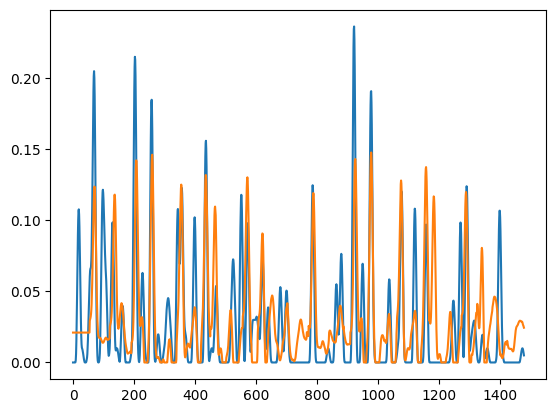

In [55]:
def generate_prediction(pair, ridge, laguerre_args, ridge_conv_filter, nPoints=200, nLaguerre=5):
    x = generate_laguerre_features(pair, 'spect_pca_features',  laguerre_args, nLaguerrePoints=nPoints, nLaguerre=nLaguerre)
    #y_avg = gen_y_avg_laguerre(pair, laguerre_args, nPoints)
    y_avg = gen_y_avg(pair, ridge_conv_filter)
    y_pred = ridge.predict(x.T) + y_avg
    # y_pred = x.T @ weights + y_avg
    y_pred[y_pred < 0] = 0
    return y_pred

def generate_pred_score(pair, ridge, laguerre_args, ridge_conv_filter, nPoints=200, nLaguerre=5):
    x = generate_laguerre_features(pair, 'spect_pca_features',  laguerre_args, nLaguerrePoints=nPoints, nLaguerre=nLaguerre)
    #y_avg = gen_y_avg_laguerre(pair, laguerre_args, nPoints)
    y_avg = gen_y_avg(pair, ridge_conv_filter)
    y = pair['resp']['psth_smooth']
    return ridge.score(x.T, y - y_avg)
    #y_pred[y_pred < 0] = 0
    return y_pred

iSet = np.random.choice(pair_test_set)
pair = srData['datasets'][iSet]
y = pair['resp']['psth_smooth']
y_pred = generate_prediction(pair, ridge, laguerre_args, ridge_conv_filter, nPoints, nLaguerre)
print(generate_pred_score(pair, ridge, laguerre_args, ridge_conv_filter, nPoints, nLaguerre))
plt.plot(y)
plt.plot(y_pred)

In [56]:

def get_prediction_r2(pair, ridge, laguerre_args, ridge_conv_filter, nPoints, nLaguerre=5):
    y = pair['resp']['psth_smooth']
    y_pred = generate_prediction(pair, ridge, laguerre_args, ridge_conv_filter, nPoints, nLaguerre)
    return np.corrcoef(y, y_pred)[0,1]**2

all_r2_train = [get_prediction_r2(srData['datasets'][iSet], ridge, laguerre_args, ridge_conv_filter, nPoints, nLaguerre) for iSet in pair_train_set]
all_r2_test = [get_prediction_r2(srData['datasets'][iSet], ridge, laguerre_args, ridge_conv_filter, nPoints, nLaguerre) for iSet in pair_test_set]


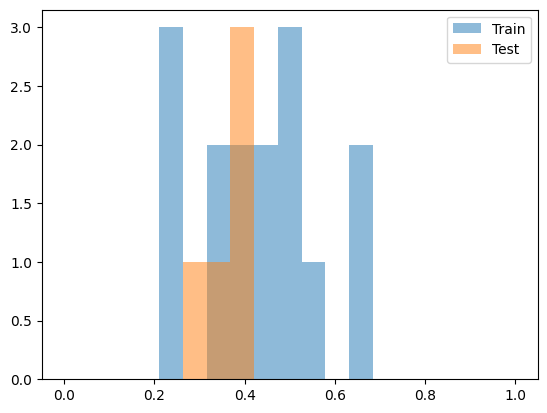

In [57]:
plt.figure()
bins = np.linspace(0, 1, 20)
plt.hist(all_r2_train, alpha=0.5,bins=bins, label='Train')
plt.hist(all_r2_test, alpha=0.5,bins=bins,label='Test')
plt.legend()

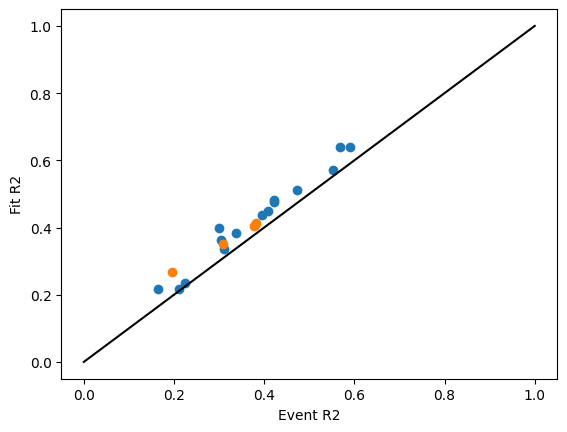

In [58]:
# make a paired box plot of the r2 values from simple to all
plt.scatter(simple_r2_train, all_r2_train, label='Train')
plt.scatter(simple_r2_test, all_r2_test, label='Test')
plt.xlabel('Event R2')
plt.ylabel('Fit R2')
# and plot the line y=x
plt.plot([0,1],[0,1], color='black')

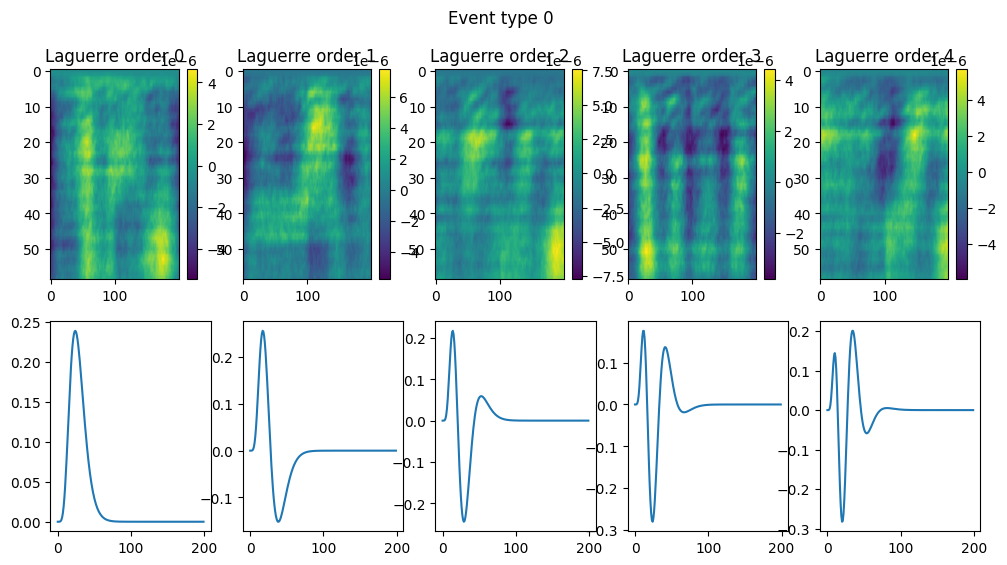

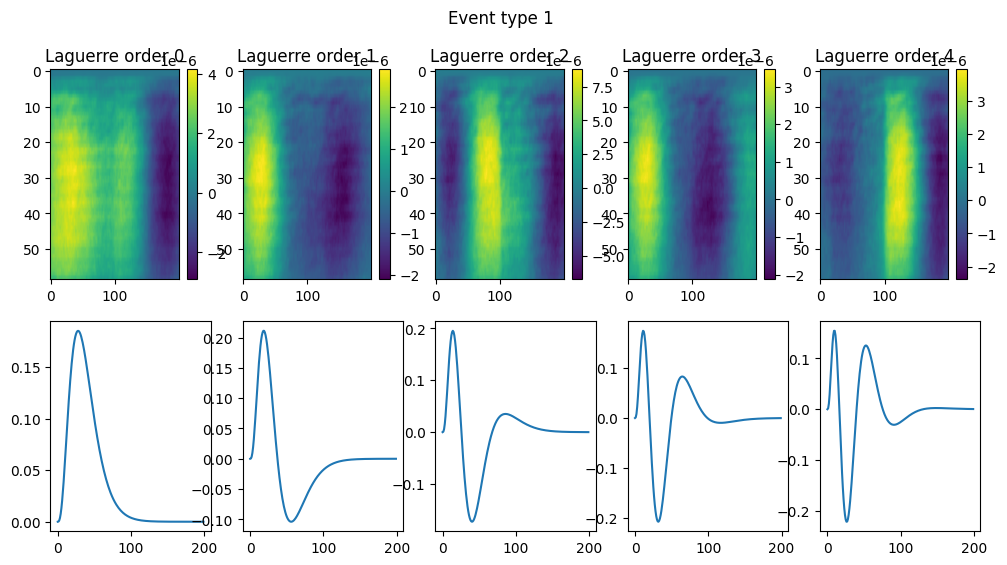

In [59]:
# weights is arranged as follows:
# for each event type there are 5 laguerre functions for each pca component
for event_type in range(2): # event type
    plt.figure(figsize=(12, 6))
    plt.suptitle(f'Event type {event_type}')
    for iLaguerre in range(nLaguerre): # num laguerre
        plt.subplot(2, nLaguerre, nLaguerre + iLaguerre+1)
        laguerre_func = laguerre(np.arange(nPoints), *laguerre_args[event_type], xorder=iLaguerre)
        plt.plot( laguerre_func / np.sqrt(np.sum(laguerre_func**2)))
        receptive_field = np.zeros((nStimChannels, respChunkLen))
        for j in range(npcs):
            receptive_field += pca.components_[j].reshape(nStimChannels, respChunkLen) * weights[event_type * (npcs * nLaguerre) + nLaguerre * j + iLaguerre]
        # now plot the receptive field
        plt.subplot(2, nLaguerre, iLaguerre+1)
        plt.imshow(receptive_field, aspect='auto', cmap='viridis')
        plt.title(f'Laguerre order {iLaguerre}')
        plt.colorbar()


In [73]:
# lets get the average spect_pca_features for both event types
all_spect_pca_features = np.concatenate([ srData['datasets'][iSet]['events']['spect_pca_features'] for iSet in range(pairCount)])
spect_pc_activations = np.mean(all_spect_pca_features,axis=0) # dimension is nEventTypes*npcs

array([22, 21,  8, 25, 23,  4,  0, 36, 38,  9, 13, 27, 34, 17, 15, 26, 39,
       30, 11, 32, 12, 31, 10, 19,  6, 35, 37, 14,  7, 33, 29, 18, 16, 20,
       24,  3,  5, 28,  1,  2])

<Figure size 2000x1200 with 0 Axes>

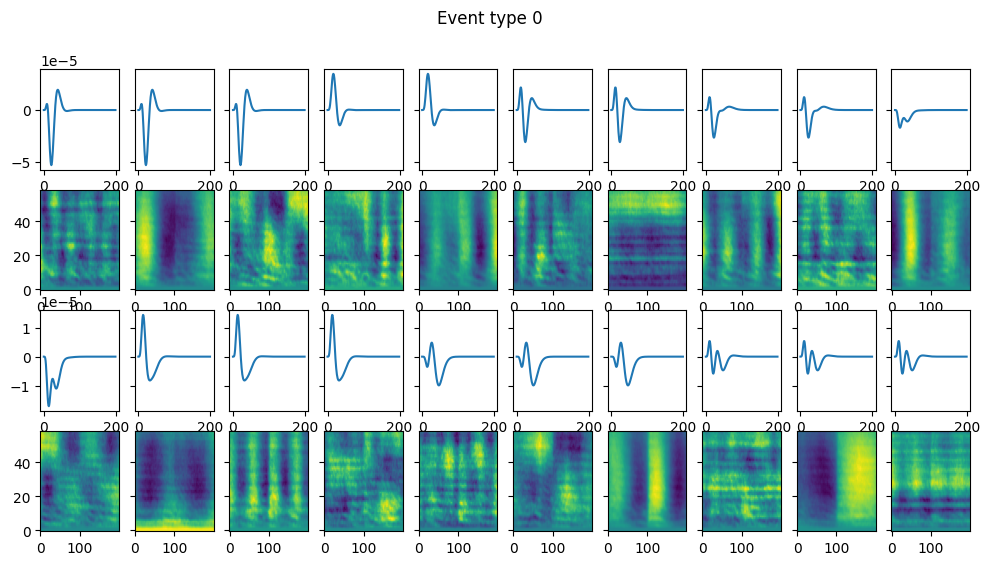

<Figure size 2000x1200 with 0 Axes>

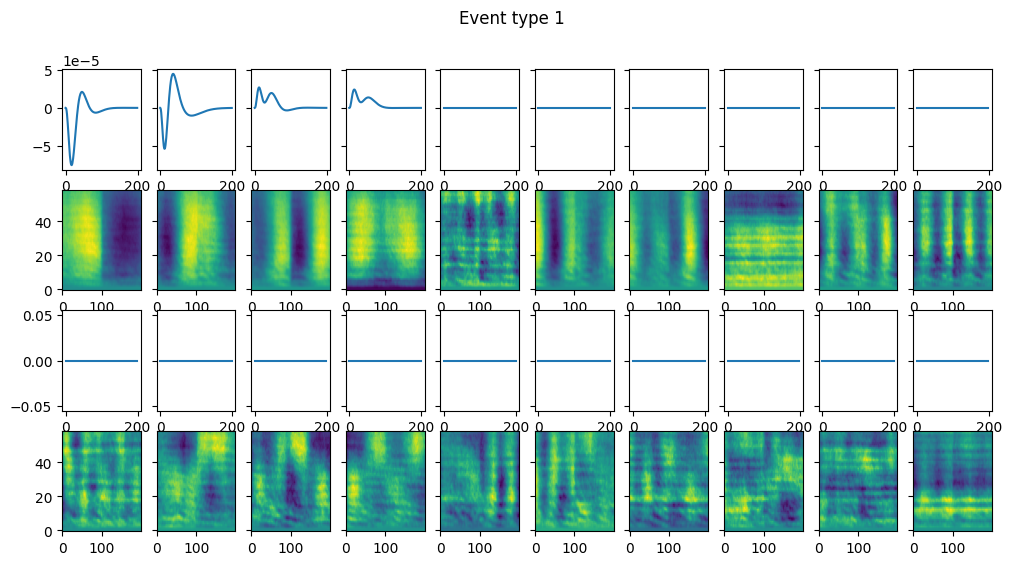

In [81]:
# The other way to view it, is to generate a response for each pca component
for event_type in range(2): # event type
    plt.figure(figsize=(20, 12))
    ncols = npcs//2
    # row 1 and 3 are the laguerre functions
    # row 2 and 4 are the pca components
    fig, axs = plt.subplots(4, ncols, figsize=(12, 6),sharey='row')
    event_spect_pc_activations = spect_pc_activations[event_type*npcs:(event_type+1)*npcs]
    plt.suptitle(f'Event type {event_type}')
    out_funcs = []
    for j in range(npcs): # np.argsort(event_spect_pc_activations**2)[::-1]:
        out_func = np.zeros(nPoints)
        for iLaguerre in range(nLaguerre):
            laguerre_func = laguerre(np.arange(nPoints), *laguerre_args[event_type], xorder=iLaguerre)
            laguerre_func = laguerre_func / np.sqrt(np.sum(laguerre_func**2))
            out_func += weights[event_type * (npcs * nLaguerre) + nLaguerre * j + iLaguerre] * laguerre_func
        out_funcs.append(out_func)
    out_func_amps = np.array([np.sqrt(np.sum(out_func**2)) for out_func in out_funcs])
    for ij,j in enumerate(np.argsort(out_func_amps)[::-1]):
        # plt.subplot(2, npcs, j+1)
        #axs[0,j].plot(out_func)
        axs[2*(ij//ncols),ij%ncols].plot(out_funcs[j])#+ learned_conv_kernel[event_type,:])

        axs[2*(ij//ncols) + 1,ij%ncols].imshow(event_spect_pc_activations[j]*pca.components_[j].reshape(nStimChannels, respChunkLen), aspect='auto', cmap='viridis', origin='lower')

        #plt.colorbar()
        


ValueError: cannot reshape array of size 1 into shape (59,200)

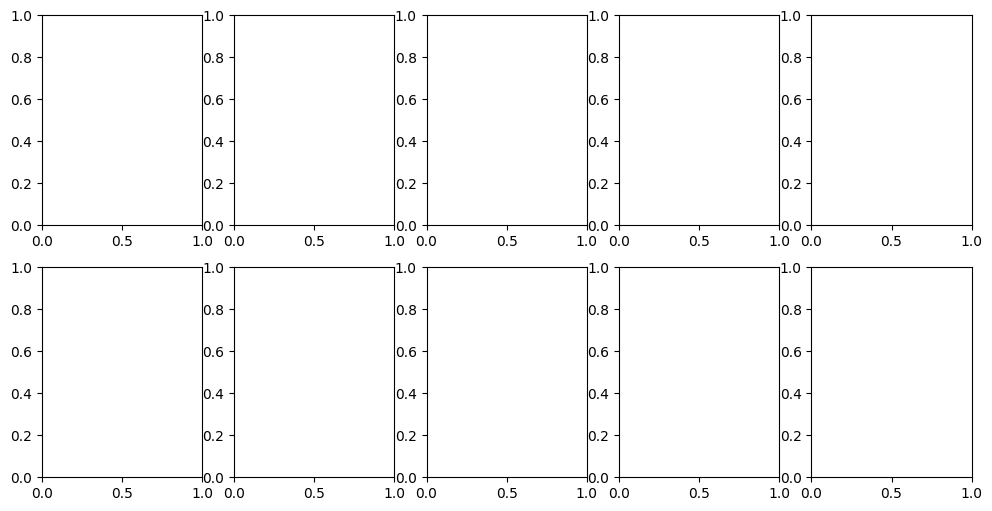

In [69]:
# now lets plot some receptive fields for each laguerre polynomial
nCols = 5
nRows = 2
fig, axs = plt.subplots(nRows, nCols, figsize=(12, 6))
for i in range(5):
    ax = axs[i // nCols, i % nCols]
    ax.imshow(weights[i].reshape(nStimChannels, respChunkLen), aspect='auto', cmap='viridis')
    ax.set_title(f'PCA {i+1}')